# **Statistics tutorial**
In this second tutorial we will show some examples of how to executed more sofisticated analysis towards our data. Here we will not use UDFs but transformers. These kind of functions depend directly from an Oskar object, and they will not return a dataframe field but the whole dataframe again with the due transformation applied.

As we did in the previous tutorial, we need to import both Spark and Oskar APIs, as well as loading our data into a spark DataFrame.

In [1]:
from pyoskar.core import Oskar
from pyoskar.sql import *
from pyoskar.analysis import *
from pyspark.sql.functions import col, udf, count, explode, concat, when, expr
from pyspark.sql.functions import *

oskar = Oskar(spark)
df = oskar.load("/home/roldanx/appl/oskar/oskar-spark/src/test/resources/platinum_chr22.small.parquet")

## Stats per variant
Here we present the genotypes of the first 10 variants from which the later stats will come out:

In [2]:
df.select(df.id, df.studies.samplesData.alias("genotypes")).show(10, False)

+---------------+-------------------------------------------------------------------------------------------------------------------------+
|id             |genotypes                                                                                                                |
+---------------+-------------------------------------------------------------------------------------------------------------------------+
|22:16054454:C:T|[[[./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [0/1], [./.], [./.], [./.]]]|
|22:16065809:T:C|[[[0/1], [./.], [./.], [./.], [0/1], [./.], [0/1], [./.], [./.], [./.], [./.], [0/1], [0/1], [./.], [./.], [./.], [0/1]]]|
|22:16077310:T:A|[[[./.], [0/1], [0/1], [./.], [./.], [0/1], [./.], [0/1], [./.], [0/1], [./.], [0/1], [./.], [./.], [0/1], [./.], [./.]]]|
|22:16080499:A:G|[[[0/1], [./.], [0/1], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [./.], [0/1], [0/1], [./.], [./.], [./.], [./.]]]|
|22:16084621:T:C|[[[

In this case we are applying a transformation that will lead to adding new data inside the "studies" field, which is empty before we do anything:

In [20]:
df.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "refAlleleCount", "altAlleleCount", "missingAlleleCount", "missingGenotypeCount", "refAlleleFreq", "altAlleleFreq").show(10, False)

+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|id             |alleleCount|refAlleleCount|altAlleleCount|missingAlleleCount|missingGenotypeCount|refAlleleFreq|altAlleleFreq|
+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|22:16054454:C:T|null       |null          |null          |null              |null                |null         |null         |
|22:16065809:T:C|null       |null          |null          |null              |null                |null         |null         |
|22:16077310:T:A|null       |null          |null          |null              |null                |null         |null         |
|22:16080499:A:G|null       |null          |null          |null              |null                |null         |null         |
|22:16084621:T:C|null       |null          |null          |null              |null                |null 

Now we proceed to call our [<span style="color:#FF1493"> **stats** </span>] transformer through our "oskar" instance. That means that our dataframe will suffer some kind of change. It is important to know how transformers work in order to tell spark how to extract the new information:

In [23]:
statsDF = oskar.stats(df)
statsDF.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "refAlleleCount", "altAlleleCount", "missingAlleleCount", "missingGenotypeCount", "refAlleleFreq", "altAlleleFreq").show(10, False)

+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|id             |alleleCount|refAlleleCount|altAlleleCount|missingAlleleCount|missingGenotypeCount|refAlleleFreq|altAlleleFreq|
+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|22:16054454:C:T|2          |1             |1             |32                |16                  |0.5          |0.5          |
|22:16065809:T:C|12         |6             |6             |22                |11                  |0.5          |0.5          |
|22:16077310:T:A|14         |7             |7             |20                |10                  |0.5          |0.5          |
|22:16080499:A:G|8          |4             |4             |26                |13                  |0.5          |0.5          |
|22:16084621:T:C|10         |5             |5             |24                |12                  |0.5  

Since our data has some empty genotypes, we would like to treat those missing values as if they were the reference. For that task we dispose of "missingAsReference" parameter:

In [22]:
missingAsReferenceStatsDF = oskar.stats(df, missingAsReference=True)
missingAsReferenceStatsDF.selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "alleleCount", "refAlleleCount", "altAlleleCount", "missingAlleleCount", "missingGenotypeCount", "refAlleleFreq", "altAlleleFreq").show(10, False)

+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|id             |alleleCount|refAlleleCount|altAlleleCount|missingAlleleCount|missingGenotypeCount|refAlleleFreq|altAlleleFreq|
+---------------+-----------+--------------+--------------+------------------+--------------------+-------------+-------------+
|22:16054454:C:T|34         |33            |1             |0                 |0                   |0.9705882    |0.029411765  |
|22:16065809:T:C|34         |28            |6             |0                 |0                   |0.8235294    |0.1764706    |
|22:16077310:T:A|34         |27            |7             |0                 |0                   |0.7941176    |0.20588236   |
|22:16080499:A:G|34         |30            |4             |0                 |0                   |0.88235295   |0.11764706   |
|22:16084621:T:C|34         |29            |5             |0                 |0                   |0.852

Other statistics that our method provides are the next ones:

In [18]:
oskar.stats(df, missingAsReference=True).selectExpr("id", "studies[0].stats.ALL as stats").select("id", "stats.*")\
    .select("id", "genotypeCount", "genotypeFreq", "mafAllele", "maf", "mgfGenotype", "mgf").show(10, False)

+---------------+---------------------+-------------------------------------------------+---------+-----------+-----------+---+
|id             |genotypeCount        |genotypeFreq                                     |mafAllele|maf        |mgfGenotype|mgf|
+---------------+---------------------+-------------------------------------------------+---------+-----------+-----------+---+
|22:16054454:C:T|[0/0 -> 16, 0/1 -> 1]|[0/0 -> 0.9411765, 0/1 -> 0.05882353, 1/1 -> 0.0]|T        |0.029411765|1/1        |0.0|
|22:16065809:T:C|[0/0 -> 11, 0/1 -> 6]|[0/0 -> 0.64705884, 0/1 -> 0.3529412, 1/1 -> 0.0]|C        |0.1764706  |1/1        |0.0|
|22:16077310:T:A|[0/0 -> 10, 0/1 -> 7]|[0/0 -> 0.5882353, 0/1 -> 0.4117647, 1/1 -> 0.0] |A        |0.20588236 |1/1        |0.0|
|22:16080499:A:G|[0/0 -> 13, 0/1 -> 4]|[0/0 -> 0.7647059, 0/1 -> 0.23529412, 1/1 -> 0.0]|G        |0.11764706 |1/1        |0.0|
|22:16084621:T:C|[0/0 -> 12, 0/1 -> 5]|[0/0 -> 0.7058824, 0/1 -> 0.29411766, 1/1 -> 0.0]|C        |0.147

## Stats per dataframe
We could also use [<span style="color:#FF1493"> **globalStats** </span>] that provides statistics attached to the whole dataframe. Some fields will be given as *int* and *float*:

In [2]:
globalStatsTransformationDataframe = oskar.globalStats(df)
globalStatsTransformationDataframe.select("numVariants", "numSamples", "numPass", "tiTvRatio", "meanQuality", "stdDevQuality").show()

+-----------+----------+-------+---------+-----------+-------------+
|numVariants|numSamples|numPass|tiTvRatio|meanQuality|stdDevQuality|
+-----------+----------+-------+---------+-----------+-------------+
|       1000|         0|   4016|1.3342036|    773.252|    765.54596|
+-----------+----------+-------+---------+-----------+-------------+



Others are returned as *array*, although in this case it is empty:

In [41]:
globalStatsTransformationDataframe.select(globalStatsTransformationDataframe.numRareVariants).show()

+---------------+
|numRareVariants|
+---------------+
|             []|
+---------------+



And others will be given as *map*:

In [30]:
globalStatsTransformationDataframe = oskar.globalStats(df)
globalStatsTransformationDataframe.select(explode("variantTypeCounts").alias("variantTypeCounts", "value")).show()
globalStatsTransformationDataframe.select(explode("variantBiotypeCounts").alias("variantBiotypeCounts", "value")).show(truncate=False)
globalStatsTransformationDataframe.select(explode("consequenceTypesCounts").alias("consequenceTypesCounts", "value")).show(truncate=False)
globalStatsTransformationDataframe.select(explode("chromosomeStats").alias("chromosomeStats", "value")).show(truncate=False)

+-----------------+-----+
|variantTypeCounts|value|
+-----------------+-----+
|              SNV|  894|
|            INDEL|  106|
+-----------------+-----+

+----------------------------------+-----+
|variantBiotypeCounts              |value|
+----------------------------------+-----+
|IG_C_pseudogene                   |1    |
|IG_V_pseudogene                   |17   |
|protein_coding                    |500  |
|rRNA                              |4    |
|retained_intron                   |192  |
|nonsense_mediated_decay           |166  |
|IG_V_gene                         |18   |
|snRNA                             |6    |
|snoRNA                            |6    |
|transcribed_processed_pseudogene  |4    |
|unitary_pseudogene                |2    |
|IG_J_gene                         |4    |
|transcribed_unprocessed_pseudogene|40   |
|pseudogene                        |1    |
|IG_C_gene                         |4    |
|sense_intronic                    |10   |
|processed_pseudogene     

## Histogram
This next example shows how easily we can complement Pyoskar API functionality and at the same time we use some well known python functionality like pandas or plotly. We would like to know the frequency with which we can find variants depending on the region of our genome.

In [4]:
oskar.histogram(df,"start",1000000).show()

+--------+-----+
|   start|count|
+--------+-----+
|16000000|  101|
|17000000|  100|
|18000000|   85|
|19000000|   53|
|20000000|   46|
|21000000|   85|
|22000000|   52|
|23000000|   49|
|24000000|   44|
|25000000|   62|
|26000000|   42|
|27000000|   54|
|28000000|   21|
|29000000|   29|
|30000000|   38|
|31000000|   46|
|32000000|   44|
|33000000|   34|
|34000000|   15|
+--------+-----+



For that we will give use to the [<span style="color:#FF1493"> **histogram** </span>] Pyoskar transformation, but after it we will store our transformed dataframe into a Pandas Dataframe in order to plot it later with the default "toPandas()" Pyspark method:

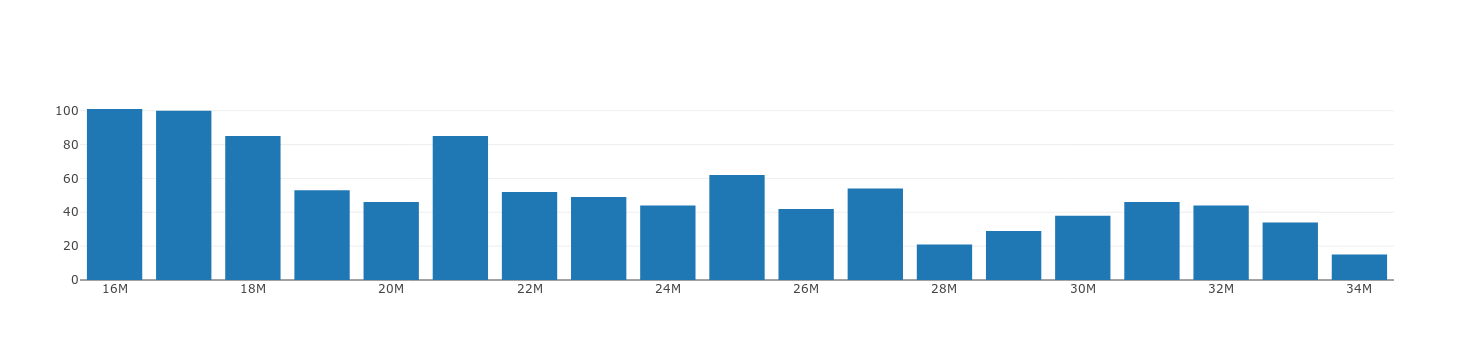

In [42]:
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import get_plotlyjs, init_notebook_mode

pandasHistogramDF = oskar.histogram(df,"start",1000000).toPandas()

init_notebook_mode(connected=True)

data = [go.Bar(x=pandasHistogramDF["start"], y=pandasHistogramDF["count"])]
py.iplot(data)

** Note that the region covers from the self x-axis value to the next one*

** If you are using jupyter lab you will need to download this extension https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension to visualize the plot*

# Identity by state
Some other interesting stats we may want to acces is IBS coefficient, wich could give us important information about variant similarity. For that we count on [<span style="color:#FF1493"> **ibs** </span>] transformer:

In [12]:
oskar.ibs(df).show(10)

+------------------+------------------+------------+--------+----+
|        samplePair|          distance|      counts|variants|skip|
+------------------+------------------+------------+--------+----+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|
|[NA12877, NA12880]|0.9028662420382165|[0, 61, 253]|     314| 686|
|[NA12877, NA12881]|0.9116719242902208|[0, 56, 261]|     317| 683|
|[NA12877, NA12882]|0.8934707903780069|[0, 62, 229]|     291| 709|
|[NA12877, NA12883]| 0.891156462585034|[0, 64, 230]|     294| 706|
|[NA12877, NA12884]|0.8904109589041096|[0, 64, 228]|     292| 708|
|[NA12877, NA12885]|0.9115755627009646|[0, 55, 256]|     311| 689|
|[NA12877, NA12886]| 0.909967845659164|[0, 56, 255]|     311| 689|
|[NA12877, NA12887]|0.9096989966555183|[0, 54, 245]|     299| 701|
+------------------+------------------+------------+--------+----+
only showing top 10 rows



In case we don't specify any samples it will run the whole dataframe samples, but we may want to check similarity between concrete individuals:

In [13]:
oskar.ibs(df, samples=["NA12877", "NA12878", "NA12879"]).show(10)

+------------------+------------------+------------+--------+----+
|        samplePair|          distance|      counts|variants|skip|
+------------------+------------------+------------+--------+----+
|[NA12877, NA12878]|0.8928571428571429|[0, 57, 209]|     266| 734|
|[NA12877, NA12879]|0.9155629139072847|[0, 51, 251]|     302| 698|
|[NA12878, NA12879]|0.8857615894039735|[0, 69, 233]|     302| 698|
+------------------+------------------+------------+--------+----+



<span style="color:yellow"> **COMENTO LOS POSIBLES PARÁMETROS??** </span>

In [37]:
oskar.ibs(df).printSchema()
OskarIBS = oskar.ibs(df).toPandas()
samples = [sample[0] for sample in OskarIBS.samplePair]
print(samples)

root
 |-- samplePair: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- distance: double (nullable = true)
 |-- counts: array (nullable = true)
 |    |-- element: integer (containsNull = false)
 |-- variants: integer (nullable = true)
 |-- skip: integer (nullable = true)

['NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12877', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12878', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12879', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12880', 'NA12881', 'NA12881', 'NA12881', 'NA12881', 'NA12881', 'NA128

# **Advanced variant filtering**

## Hardy Weinberg

In [13]:
oskar.hardyWeinberg(df,"hgvauser@platinum:illumina_platinum").select("id", "HWE").show(10)

+---------------+--------------------+
|             id|                 HWE|
+---------------+--------------------+
|22:16054454:C:T|                 1.0|
|22:16065809:T:C|                 1.0|
|22:16077310:T:A|  0.9254727474972191|
|22:16080499:A:G|                 1.0|
|22:16084621:T:C|                 1.0|
|22:16091610:G:T|                 1.0|
|22:16096040:G:A|  0.4746014089729329|
|22:16099957:C:T|0.016007636455477054|
|22:16100462:A:G|0.001011008618240...|
|22:16105660:G:A|  0.3037449017426771|
|22:16112391:G:A| 0.17718452601656157|
|22:16114913:A:T|  0.6855353685164587|
|22:16127471:A:-|                 1.0|
|22:16134019:G:T| 0.17718452601656157|
|22:16138943:C:G|  0.6855353685164587|
|22:16144239:T:C| 0.18181818181818182|
|22:16147398:G:A|0.001011224592982...|
|22:16149692:G:T| 0.08884238232789762|
|22:16195955:G:A|0.007751066073178...|
|22:16196041:C:T|  0.6855353685164587|
|22:16202382:C:T|0.001011008618240...|
|22:16212765:C:T|                 1.0|
|22:16223351:C:T|        

## Inbreeding coefficient

In [49]:
df2 = oskar.stats(df, studyId="hgvauser@platinum:illumina_platinum", missingAsReference=True)
oskar.inbreedingCoefficient(df2).show(10)

+--------+-------------------+-----------+------------------+--------------+
|SampleId|                  F|ObservedHom|       ExpectedHom|GenotypesCount|
+--------+-------------------+-----------+------------------+--------------+
| NA12877|-1.0857581722788996|         70|233.97577702999115|           385|
| NA12878|-1.1024114888695444|         69|244.65916746854782|           404|
| NA12879|-1.1890914293957586|         69| 247.7093403339386|           398|
| NA12880|-1.1013660394101679|         71|248.15224742889404|           409|
| NA12881|-1.1560267972581504|         65| 252.6643579006195|           415|
| NA12882|-1.0112382612189488|         76| 224.8269881606102|           372|
| NA12883|-1.0602574055431329|         67|229.62110525369644|           383|
| NA12884|-1.0340014363992485|         74|224.47404664754868|           370|
| NA12885|-1.1105665251221366|         78| 254.8010356426239|           414|
| NA12886| -1.067867784696387|         72|244.48096668720245|           406|

## Mendelian error

In [6]:
oskar.mendel(df, "NA12877", "NA12878", "NA12879").select("id", "mendelianError").filter(col("mendelianError") != "0").show()

+------------------+--------------+
|                id|mendelianError|
+------------------+--------------+
|22:19748211:CCCC:-|             1|
+------------------+--------------+

